In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# use path if the file is open using the github repository
# path = '../dataset/cleaned_data.csv'

# The path is specific you my(Jainish) directory only.
path = "/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv"
data = pd.read_csv(path)
print(data.head())

                                                text  generated
0  carfree cities become subject increasing inter...          1
1  car free cities carfree cities concept gaining...          1
2  sustainable urban future carfree cities emergi...          1
3  pioneering sustainable urban living era marked...          1
4  path sustainable urban living age rapid urbani...          1


In [4]:
data['text'].isna().sum()

1

In [5]:
data['text'] = data['text'].fillna('')

In [6]:
data['text'].isna().sum()

0

In [7]:
data['generated'].isna().sum()

0

<function matplotlib.pyplot.show(close=None, block=None)>

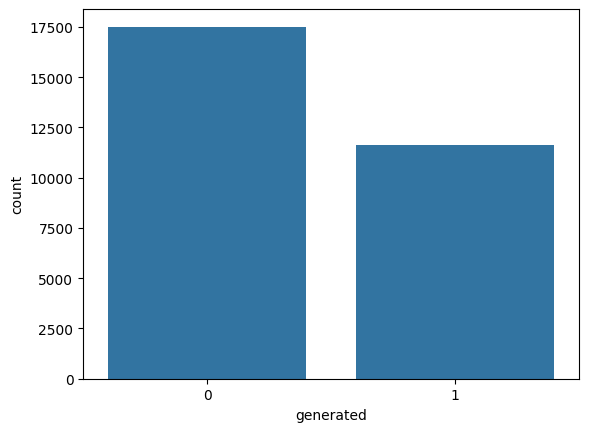

In [9]:
sns.countplot(x=data['generated'])
plt.show

In [10]:
def balance_labels(df, label_column='generated'):
    label_counts=df[label_column].value_counts()
    max_count=label_counts.max()

    balanced_df=pd.DataFrame()

    for label, count in label_counts.items():
        label_subset = df[df[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)

    return balanced_df

In [12]:
data=balance_labels(data)

<function matplotlib.pyplot.show(close=None, block=None)>

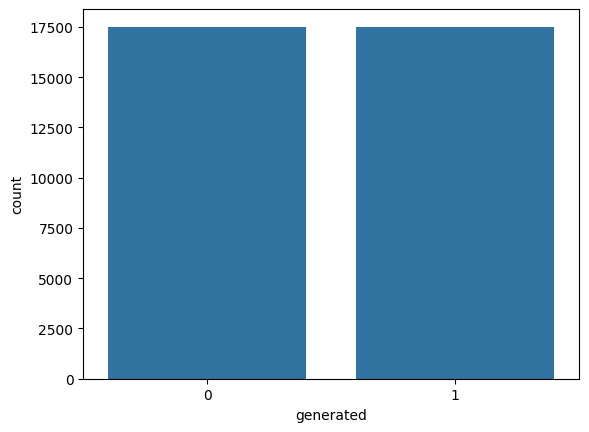

In [13]:
sns.countplot(x=data['generated'])
plt.show

In [14]:
X= data['text']
y= data['generated']

In [15]:
texts = data['text'].tolist()
labels = data['generated'].tolist()

In [16]:
X_train, X_val, y_train, y_val= train_test_split(texts, labels, test_size= 0.2, random_state= 42)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=256)

In [19]:
def encode_labels(labels):
    return tf.keras.utils.to_categorical(labels, num_classes=2)

train_labels = encode_labels(y_train)
val_labels = encode_labels(y_val)

def create_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    )).batch(8)  # Batch size of 8

train_dataset = create_dataset(train_encodings, train_labels)
val_dataset = create_dataset(val_encodings, val_labels)

In [21]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
3502/3502 [==============================] - 1838s 509ms/step - loss: 0.0539 - accuracy: 0.9836 - val_loss: 0.0161 - val_accuracy: 0.9960
Epoch 2/3
3502/3502 [==============================] - 1773s 506ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0113 - val_accuracy: 0.9973
Epoch 3/3
3502/3502 [==============================] - 1769s 505ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0156 - val_accuracy: 0.9969


In [25]:
y_pred_probs = model.predict(val_dataset)
print("Shape of y_pred_probs:", y_pred_probs.logits.shape)

y_pred = np.argmax(y_pred_probs.logits, axis=1)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

876/876 [==============================] - 138s 157ms/step
Shape of y_pred_probs: (7004, 2)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3472
           1       1.00      1.00      1.00      3532

    accuracy                           1.00      7004
   macro avg       1.00      1.00      1.00      7004
weighted avg       1.00      1.00      1.00      7004

[[3460   12]
 [  10 3522]]


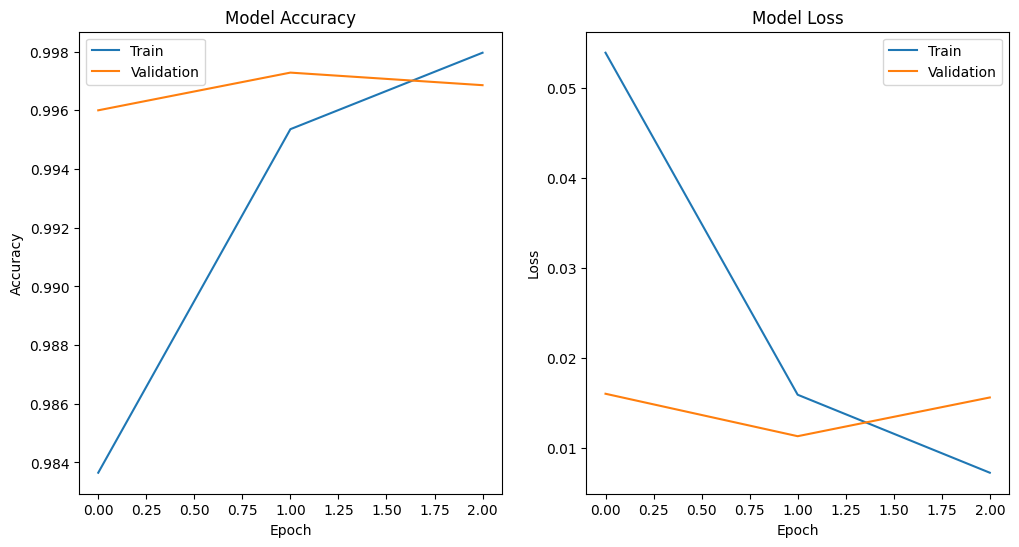

In [26]:
# Ploting training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Ploting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [27]:
# path = '../dataset/unseen_test_data.csv'
test_data_path = "/content/drive/MyDrive/Colab Notebooks/unseen_test_data.csv"
test_data = pd.read_csv(test_data_path)
print(test_data.head())

                                                text  generated
0  The process of chosing a president should be c...          0
1  Should we keep the Electoral College or changi...          0
2  Limiting car usage has numerous advantages for...          1
3  Advantages of Limiting Car Usage\n \n Limiting...          1


## use below cell only when the ipynb file is running on local machine

In [ ]:
# use this cell only when the ipynb file is running on local machine
import torch
from transformers import TFBertForSequenceClassification, BertForSequenceClassification

# Loading TensorFlow model
model_name = 'bert-base-uncased'
tf_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Saving the tensorFlow model and converting it to PyTorch
tf_model.save_pretrained('model-bert-1')
pt_model = BertForSequenceClassification.from_pretrained('model-bert-1', from_tf=True)

# Saving the PyTorch model as .pt
torch.save(pt_model.state_dict(), 'model.pt')

print("Model saved as model.pt")

In [42]:
# This cell is specific you my(Jainish) directory only.
import torch
from transformers import TFBertForSequenceClassification, BertForSequenceClassification

# Step 1: Loading TensorFlow model
model_name = 'bert-base-uncased'
tf_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Step 2: Saveing the tensorFlow model and converting it to PyTorch
tf_model.save_pretrained('.//content/drive/MyDrive/Colab Notebooks/model-bert-1')
pt_model = BertForSequenceClassification.from_pretrained('.//content/drive/MyDrive/Colab Notebooks/model-bert-1', from_tf=True)

# Step 3: Saving the PyTorch model as .pt
torch.save(pt_model.state_dict(), 'model.pt')

print("Model saved as model.pt")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


Model saved as model.pt
